# Slippage Analysis

When evaluating a strategy using backtest results, we often want to know how sensitive it's performance is to implementation shortfall or slippage. pyfolio's transactions tear sheet can create "slippage sweep" plots that display strategy performance under various slippage assumptions. 

Additional per-dollar slippage can be applied to returns before running a tear sheet by providing `create_full_tear_sheet` with the a level of slippage in basis points (1% == 100 basis points) as the `slippage` keyword argument. The slippage plots in the transactions tear sheet will display returns with slippage added to the **unadjusted** returns. 

For example, if you run a backtest with no transaction costs and call `create_full_tear_sheet(returns, positions, transactions, slippage=5)`, 5 bps of slippage will be applied to `returns` before all plots and figures, with the exception of the slippage sweep plots, are generated.

It is important to emphasize that the slippage plots will display performance under **additional** slippage. If the passed performance data already has slippage applied, the 5 bps slippage equity curve will represent performance under 5 bps of slippage in addition to the already simulated slippage penalty. If slippage is already applied to the performance results, pass `slippage=0` to the `create_full_tear_sheet` to trigger the creation of the additional slippage sweep plots without applying any additional slippage to the returns time series used throughout the rest of the tear sheet.

In [1]:
# 一樣進行import
%matplotlib inline
import sys 
sys.path.append('C://Users//zyx//Documents//GitHub//quantopian//jettool')
import pyfolio as pf

import pandas
# silence warnings
import warnings
warnings.filterwarnings('ignore')

C://Users//zyx//Documents//GitHub//jettool\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [116]:
import gzip
# 讀取quantopian提供的範例檔
transactions = pandas.read_csv(gzip.open('jettool/pyfolio/tests/test_data/test_txn.csv.gz'),
                    index_col=0, parse_dates=True)
positions = pandas.read_csv(gzip.open('jettool/pyfolio/tests/test_data/test_pos.csv.gz'),
                    index_col=0, parse_dates=True)
returns = pandas.read_csv(gzip.open('jettool/pyfolio/tests/test_data/test_returns.csv.gz'),
                    index_col=0, parse_dates=True, header=None)[1]


In [58]:
# 或是讀取範例檔案
hold_df = pandas.read_csv('hold_df.csv')
roi_df = pandas.read_csv('roi_df.csv')
data = pandas.read_csv('listed_data.csv')
data = data[data['zdate']>'2018-12-31'].reset_index(drop=True)
hold_df['coid'] = hold_df['coid'].astype(str)
data['coid'] = data['coid'].astype(str)
data = data.merge(hold_df,on=['zdate','coid'],how='left')
#將靜態持股與股價整合，後面會用到
this_hold_df

,zdate,coid,持股數,收盤價(元)
0,2019-01-02,9958,0.0,61.10
1,2019-01-03,9958,0.0,58.30
2,2019-01-04,9958,0.0,52.50
3,2019-01-07,9958,0.0,52.80
4,2019-01-08,9958,0.0,52.50
...,...,...,...,...
262022,2020-04-07,1101,0.0,39.95
262023,2020-04-08,1101,0.0,41.00
262024,2020-04-09,1101,0.0,40.55
262025,2020-04-10,1101,0.0,41.00


In [69]:
#產生transactions交易資料，也就是付多少錢買多少股的資料
data_hold_df = None
last_hold_df = None
for this_date in hold_df['zdate'].unique():
    this_hold_df = data.loc[data['zdate']==this_date,['zdate','coid','持股數','收盤價(元)']].reset_index(drop=True)
    #this_hold_df = hold_df[hold_df['zdate']==this_date].reset_index(drop=True)
    
    if last_hold_df is None:
        this_hold_df['交易數'] = this_hold_df['持股數']
        this_hold_df['交易金額'] = -1*this_hold_df['交易數']*this_hold_df['收盤價(元)']
        data_hold_df = this_hold_df        
    else:
        this_hold_df = this_hold_df.merge(last_hold_df,on=['coid'],how='outer').fillna(0)
        this_hold_df['zdate'] = this_date
        this_hold_df['交易數'] = this_hold_df['持股數'] - this_hold_df['前期持股數']
        this_hold_df['交易金額'] = -1*this_hold_df['交易數']*this_hold_df['收盤價(元)']
        data_hold_df = data_hold_df.append(this_hold_df,sort=False)
    last_hold_df = this_hold_df.loc[this_hold_df['zdate']==this_date,['coid','持股數']].copy().rename(columns={'持股數':'前期持股數'})
#.rename(columns={'持股數':amount,'收盤價(元)':'price'})
data_hold_df = data_hold_df.fillna(0)
data_hold_df['持有淨現值'] = data_hold_df['持股數'] * data_hold_df['收盤價(元)'] 

In [119]:
# 產生交易檔
last_cash = 10000000
transactions = data_hold_df.loc[data_hold_df['交易數']!=0,['zdate','coid','收盤價(元)','交易數','交易金額']]
transactions = transactions.rename(columns={'coid':'symbol','收盤價(元)':'price','交易數':'amount','交易金額':'txn_dollars'})
transactions['zdate'] = pandas.to_datetime(transactions['zdate'],utc=True)
transactions.set_index('zdate', drop=True, inplace=True)
# 產生靜態投組檔,cash是指帳上剩下的現金
positions = None
for this_date in data_hold_df['zdate'].unique():
    this_position = data_hold_df.loc[data_hold_df['zdate']==this_date,['coid','持有淨現值','交易金額']]
    cash = last_cash - this_position['交易金額'].sum()*-1
    this_position_df = pandas.DataFrame(this_position[['持有淨現值']].values.T,columns=this_position['coid'].values.tolist())
    this_position_df['cash'] = cash
    last_cash = cash
    this_position_df['zdate'] = this_date
    if positions is None:
        positions = this_position_df
    else:
        positions = positions.append(this_position_df,sort=False)
positions = positions.fillna(0)
positions['zdate'] = pandas.to_datetime(positions['zdate'],utc=True)
positions.set_index('zdate', drop=True, inplace=True)
data_hold_df[data_hold_df['coid']=='6277'].head(3)

,zdate,coid,持股數,收盤價(元),交易數,交易金額,前期持股數,持有淨現值
114,2019-04-15,6277,1000.0,94.3,1000.0,-94300.0,0.0,94300.0
114,2019-04-16,6277,0.0,94.3,-1000.0,94300.0,1000.0,0.0
114,2019-04-17,6277,0.0,94.1,0.0,-0.0,0.0,0.0


In [117]:
transactions.head(5)

,amount,price,sid,symbol,txn_dollars
2004-01-09 00:00:00+00:00,448,15.540000,0,AMD,-6961.920000
2004-01-09 00:00:00+00:00,4357,4.823750,1,CERN,-21017.078750
2004-01-09 00:00:00+00:00,241,30.216872,2,COST,-7282.266152
2004-01-09 00:00:00+00:00,618,34.408660,3,DELL,-21264.551880
2004-01-09 00:00:00+00:00,436,16.263945,4,GPS,-7091.080020


In [120]:
# 這是市場資料 需要Datetime index的 amount:持有量 price:收盤價 sid	symbol:股票代碼	txn_dollars:持有淨現值
transactions.head(5)

,symbol,price,amount,txn_dollars
zdate,,,,
2019-04-15 00:00:00+00:00,9945,43.25,2000.0,-86500.0
2019-04-15 00:00:00+00:00,9935,23.10,4000.0,-92400.0
2019-04-15 00:00:00+00:00,9927,31.75,2000.0,-63500.0
2019-04-15 00:00:00+00:00,9907,12.60,7000.0,-88200.0
2019-04-15 00:00:00+00:00,8473,58.10,1000.0,-58100.0


In [115]:
# 這是你的投資組合的靜態部位
positions.head(5)

,9958,9955,9946,9945,9944,9943,9942,9941,9940,9939,...,5283,4576,4572,2233,6491,6698,6592,6715,1795,6706
zdate,,,,,,,,,,,,,,,,,,,,,
2019-04-15 00:00:00+00:00,0.0,0.0,0.0,86500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-16 00:00:00+00:00,0.0,0.0,0.0,42750.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-17 00:00:00+00:00,69400.0,0.0,0.0,42800.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-18 00:00:00+00:00,0.0,0.0,0.0,41750.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-19 00:00:00+00:00,0.0,0.0,0.0,42750.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
roi_df = roi_df[['zdate','pv']]
roi_df['next_pv'] = roi_df['pv'].values[1:].tolist() +[roi_df['pv'].values[len(roi_df['pv'])-1]]
roi_df['roi'] = (roi_df['next_pv'] - roi_df['pv'])/roi_df['pv']
returns_df = roi_df[['zdate','roi']]
returns_df['zdate'] = pandas.to_datetime(returns_df['zdate'],utc=True)
returns_df.set_index('zdate', drop=True, inplace=True)
returns = returns_df['roi']
returns

zdate
2019-04-15 00:00:00+00:00    0.000480
2019-04-16 00:00:00+00:00    0.000119
2019-04-17 00:00:00+00:00   -0.000813
2019-04-18 00:00:00+00:00   -0.000268
2019-04-19 00:00:00+00:00    0.000174
                               ...   
2020-04-07 00:00:00+00:00    0.002757
2020-04-08 00:00:00+00:00    0.000960
2020-04-09 00:00:00+00:00    0.001725
2020-04-10 00:00:00+00:00    0.000007
2020-04-13 00:00:00+00:00    0.000000
Name: roi, Length: 243, dtype: float64

In [139]:
# 這是你的投資組合的績效
returns.tail(5)

zdate
2020-04-07 00:00:00+00:00    0.002757
2020-04-08 00:00:00+00:00    0.000960
2020-04-09 00:00:00+00:00    0.001725
2020-04-10 00:00:00+00:00    0.000007
2020-04-13 00:00:00+00:00    0.000000
Name: roi, dtype: float64

Start date,2019-04-15
End date,2020-04-13
Total months,11
,Backtest
Annual return,-0.448%
Cumulative returns,-0.432%
Annual volatility,1.007%
Sharpe ratio,-0.44
Calmar ratio,-0.23
Stability,0.20
Max drawdown,-1.926%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.93,2020-01-17,2020-03-18,NaT,NaN
1,0.47,2019-04-16,2019-05-22,2020-01-13,195
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


Stress Events,mean,min,max
New Normal,-0.00%,-0.40%,0.28%


Top 10 long positions of all time,max
6277,0.94%
1441,0.94%
1806,0.94%
3383,0.94%
2348,0.94%
2364,0.94%
2031,0.94%
1471,0.94%
2504,0.94%
2491,0.93%


Top 10 short positions of all time,max


Top 10 positions of all time,max
6277,0.94%
1441,0.94%
1806,0.94%
3383,0.94%
2348,0.94%
2364,0.94%
2031,0.94%
1471,0.94%
2504,0.94%
2491,0.93%


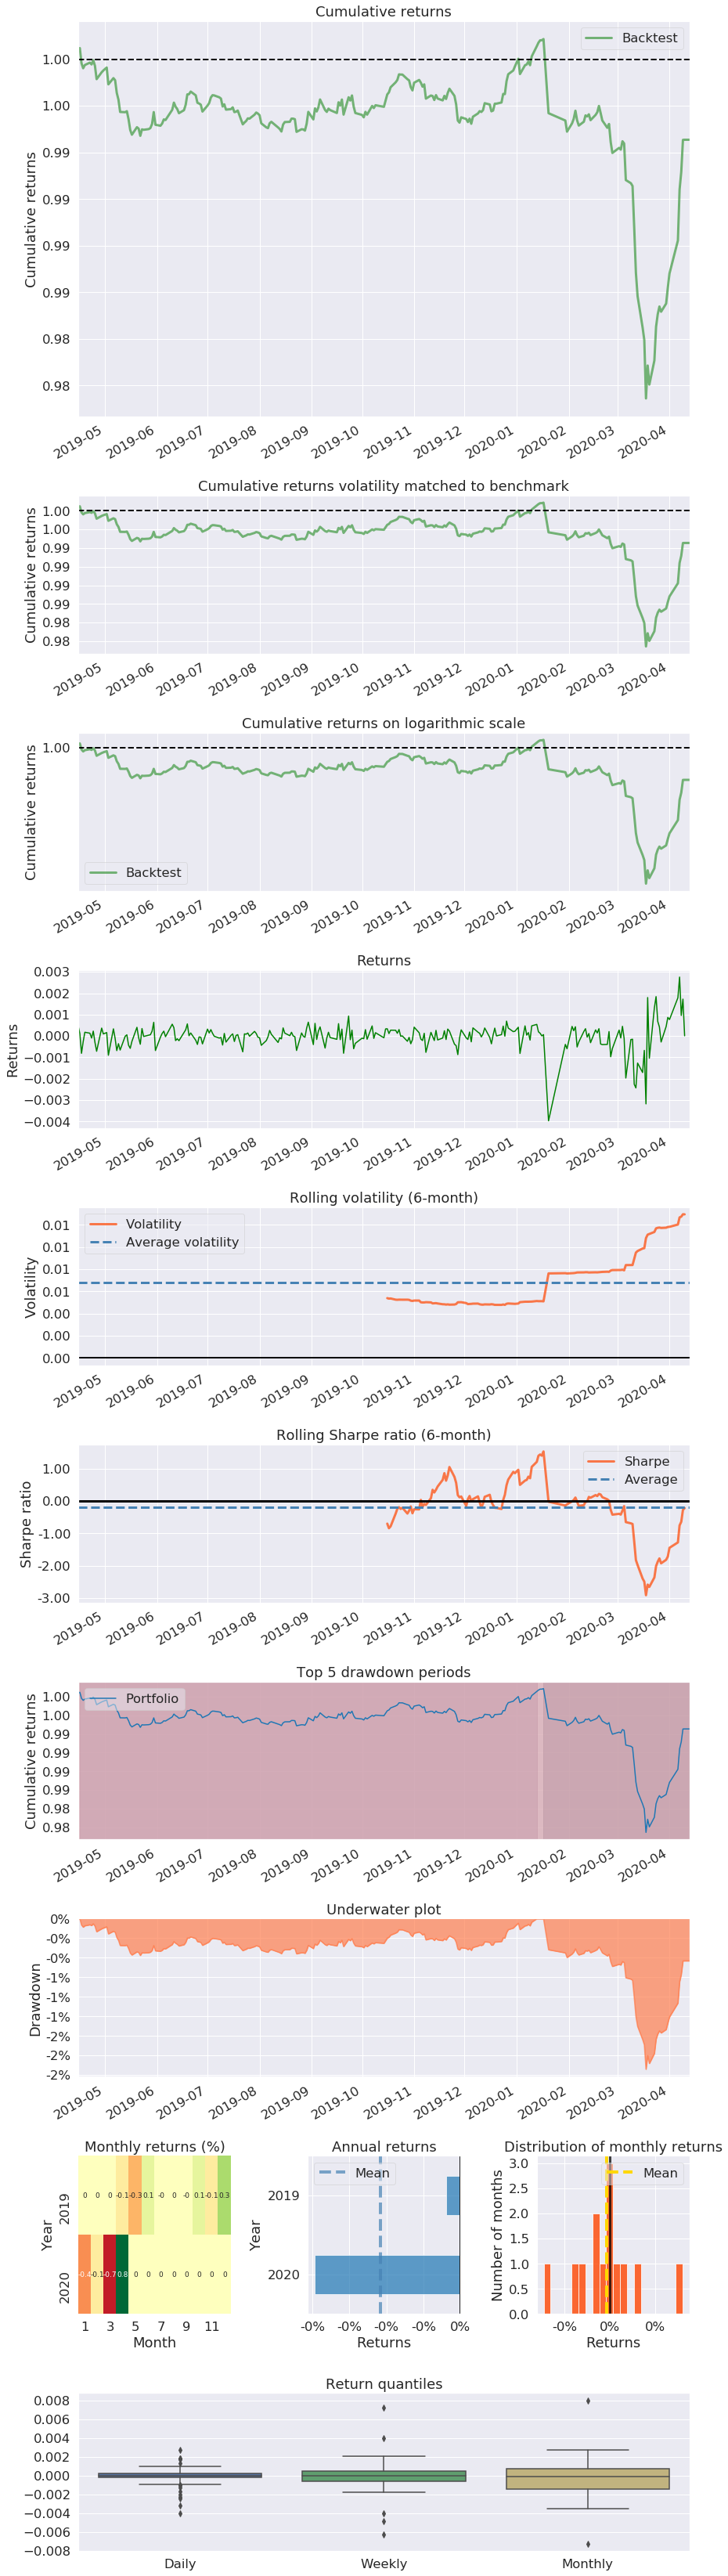

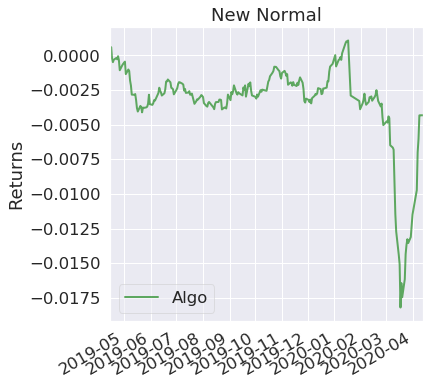

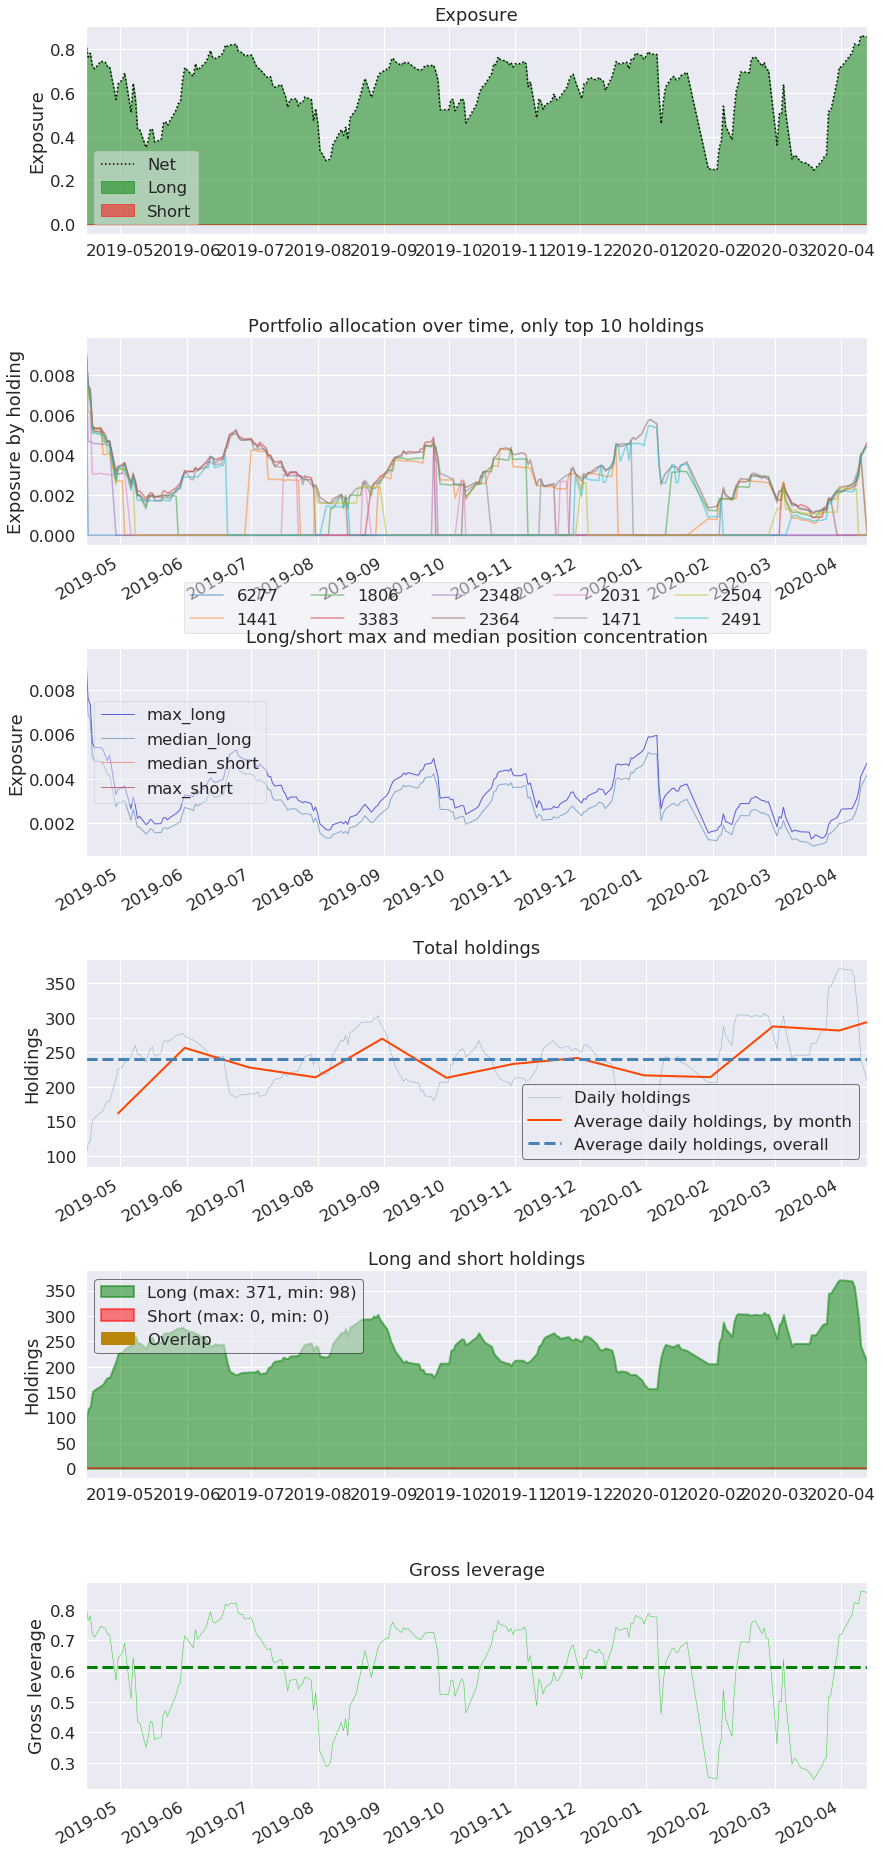

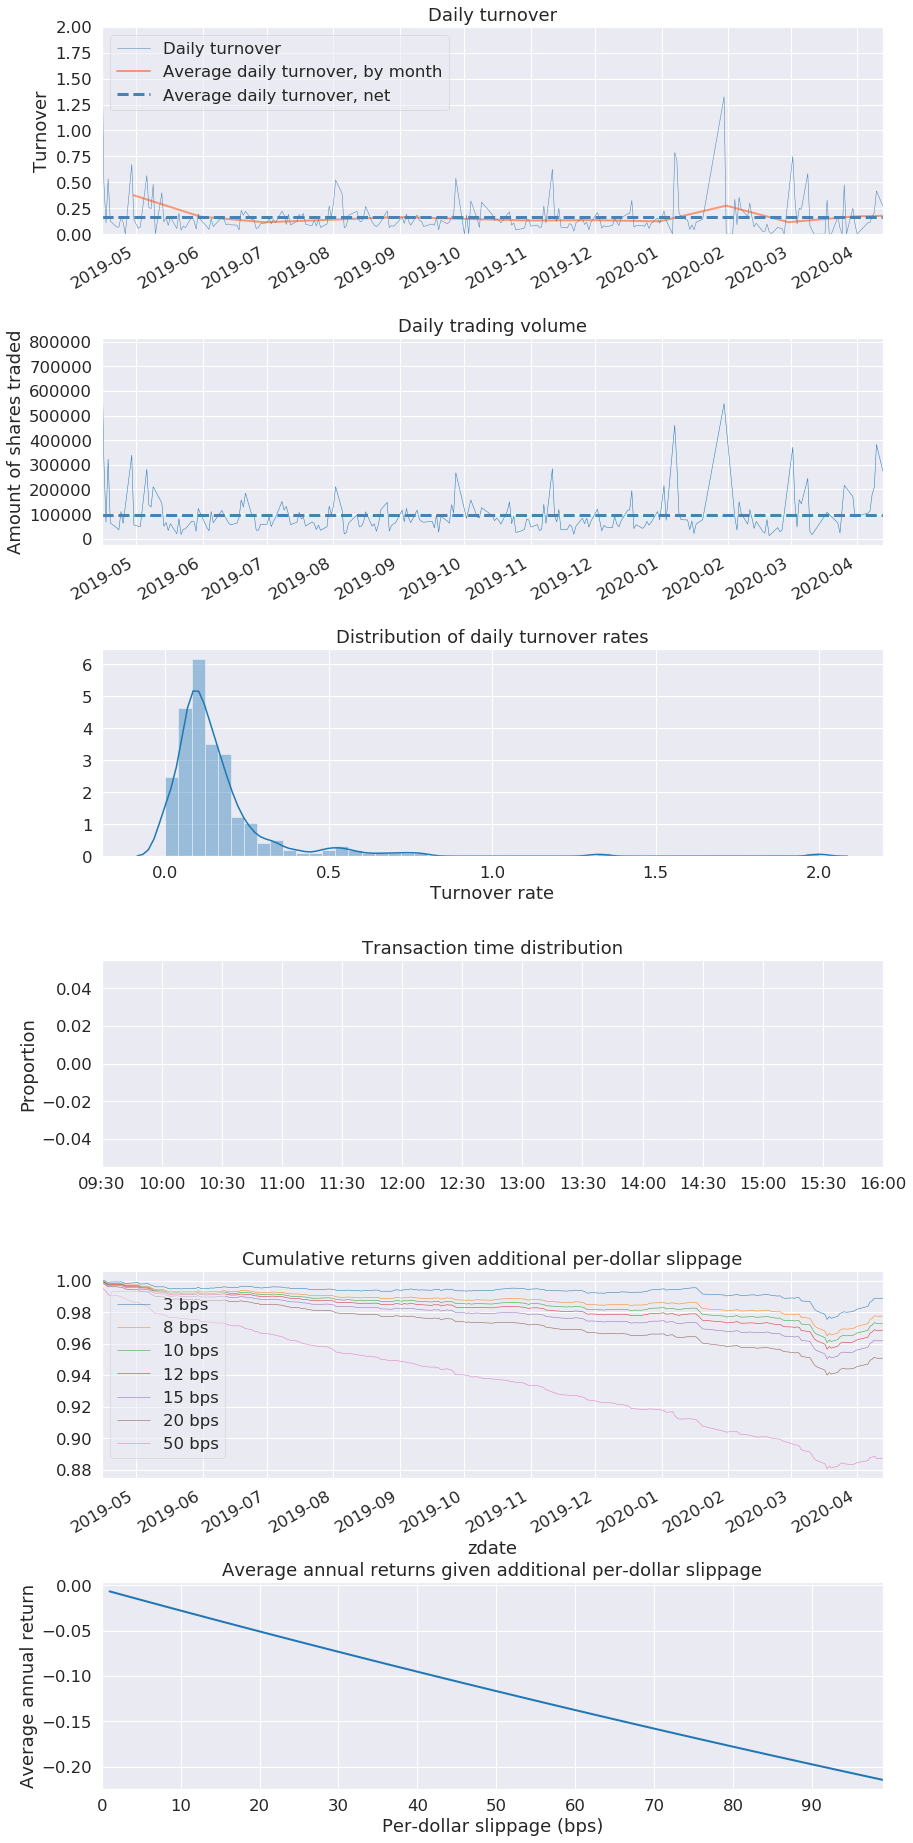

In [140]:
pf.create_full_tear_sheet(returns, positions, transactions, slippage=0)